## Set up the environment

In [45]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from src.plotting import trim_axs
pd.set_option('display.max_rows', None)


In [46]:
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_modeling'
interim_dir = f'{top_dir}/data/interim'

## Model comparisons

In [47]:
scores = []

files = glob(f'{interim_dir}/VisionEncoding/*.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0]
    scores.append(df)

files = glob(f'{interim_dir}/LLMEncoding/*orig_ordered.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0].split('_perturb')[0]
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores['model_layer_index'] = scores.model_layer_index.astype('str')
scores.set_index(['model_uid', 'model_layer_index', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.head()

model_layer  \
model_uid                                    model_layer_index stream_name                  
model-sentence-transformers_all-MiniLM-L6-v2 1                 EVC           BertModel-S1   
                                                               EVC           BertModel-S1   
                                                               EVC           BertModel-S1   
                                                               EVC           BertModel-S1   
                                                               high_lateral  BertModel-S1   

                                                                             subj_id  \
model_uid                                    model_layer_index stream_name             
model-sentence-transformers_all-MiniLM-L6-v2 1                 EVC                 1   
                                                               EVC                 2   
                                                               EVC                 3   
                                                               EVC                 4   
                                                               high_lateral        1   

                                                                                score  \
model_uid                                    model_layer_index stream_name              
model-sentence-transformers_all-MiniLM-L6-v2 1                 EVC           0.085215   
                                                               EVC           0.090636   
                                                               EVC           0.093708   
                                                               EVC           0.086458   
                                                               high_lateral  0.127022   

                                                                            method  
model_uid                                    model_layer_index stream_name          
model-sentence-transformers_all-MiniLM-L6-v2 1                 EVC           ridge  
                                                               EVC           ridge  
                                                               EVC           ridge  
                                                               EVC           ridge  
                                                               high_lateral  ridge

In [48]:
avg_scores = scores.reset_index().groupby(['model_uid', 'model_layer_index', 'stream_name']).mean().reset_index()
iter_scores = avg_scores.groupby(['model_uid', 'stream_name'])
max_scores = []
for (model_uid, stream), stream_df in iter_scores:
    idx = stream_df['score'].idxmax()
    score = tuple(stream_df.loc[idx, ['model_uid', 'model_layer_index', 'stream_name']].to_list())
    max_scores.append(scores.loc[score])
max_scores = pd.concat(max_scores).reset_index()
max_scores.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_35342/783651595.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_scores = scores.reset_index().groupby(['model_uid', 'model_layer_index', 'stream_name']).mean().reset_index()


,model_uid,model_layer_index,stream_name,model_layer,subj_id,score,method
0,model-sentence-transformers_all-MiniLM-L6-v2,58,EVC,GELUActivation-5-18,1,0.114112,ridge
1,model-sentence-transformers_all-MiniLM-L6-v2,58,EVC,GELUActivation-5-18,2,0.168275,ridge
2,model-sentence-transformers_all-MiniLM-L6-v2,58,EVC,GELUActivation-5-18,3,0.135811,ridge
3,model-sentence-transformers_all-MiniLM-L6-v2,58,EVC,GELUActivation-5-18,4,0.139918,ridge
4,model-sentence-transformers_all-MiniLM-L6-v2,44,high_lateral,LayerNorm-5-14,1,0.178044,ridge


In [49]:
streams = ['EVC']
streams += [f'{level}_{stream}' for level in ['mid', 'high'] for stream in ['ventral', 'lateral', 'parietal']]
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
max_scores['stream_name'] = max_scores['stream_name'].astype(cat_type)

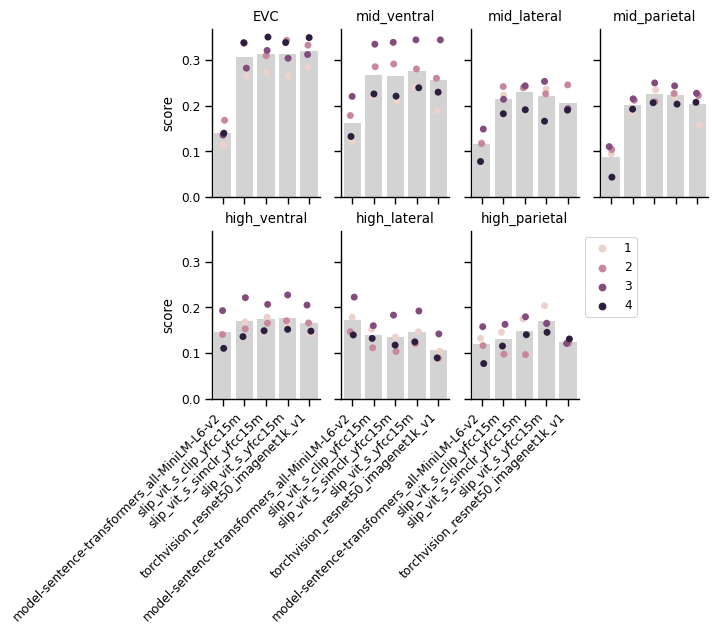

In [50]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True)
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = max_scores.groupby('stream_name')
models = max_scores.model_uid.unique()
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='model_uid', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='model_uid', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(models, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

## GLoVe perturbation experiments

In [51]:
streams = ['EVC']
streams += [f'{level}_{stream}' for level in ['mid', 'high'] for stream in ['ventral', 'lateral', 'parietal']]
perturbations = ['none', 'lemmas', 'nv',
                 'verb', 'noun', 'excnv']

In [44]:
scores = []
for perturb in perturbations:
    if perturb != 'none':
        name = perturb+'_ordered'
    else:
        name = 'none'
    print(name)
    file = f'{interim_dir}/GLoVeEncoding/{name}.csv'
    df = pd.read_csv(file)
    df['perturbation'] = perturb
    print(len(df))
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores.set_index(['perturbation', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.reset_index(inplace=True)
scores.head()

cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
scores['stream_name'] = scores['stream_name'].astype(cat_type)

cat_type = pd.CategoricalDtype(categories=perturbations, ordered=True)
scores['perturbation'] = scores['perturbation'].astype(cat_type)

none
32
lemmas_ordered
32
nv_ordered
32
verb_ordered
32
noun_ordered
32
excnv_ordered
32


,perturbation,stream_name,subj_id,score,method
0,excnv,EVC,1,-0.027923,ridge
1,excnv,EVC,2,-0.023354,ridge
2,excnv,EVC,3,-0.034732,ridge
3,excnv,EVC,4,-0.011856,ridge
4,excnv,high_lateral,1,0.026641,ridge


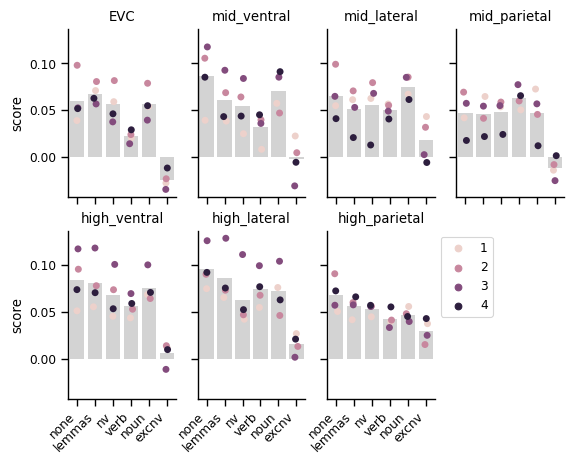

In [42]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True)
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = scores.groupby('stream_name')
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='perturbation', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='perturbation', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(perturbations, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

## SBERT perturbation experiments

In [52]:
perturbations = ['orig_shuffled', 'orig_ordered',
                 'lemmas_shuffled', 'lemmas_ordered',
                 'excnv_shuffled', 'excnv_ordered',
                 'nv_shuffled', 'nv_ordered',
                 'verb_shuffled', 'verb_ordered',
                 'noun_shuffled', 'noun_ordered']

In [56]:
scores = []
for perturb in perturbations:
    file = f'{interim_dir}/LLMEncoding/model-sentence-transformers_all-MiniLM-L6-v2_perturbation-{perturb}.csv'
    df = pd.read_csv(file)
    df['perturbation'] = perturb
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores['model_layer_index'] = scores.model_layer_index.astype('str')
scores.set_index(['perturbation', 'model_layer_index', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.head()

model_layer  subj_id     score  \
perturbation  model_layer_index stream_name                                     
excnv_ordered 1                 EVC           BertModel-S1        1  0.032054   
                                EVC           BertModel-S1        2  0.073830   
                                EVC           BertModel-S1        3  0.082615   
                                EVC           BertModel-S1        4  0.089991   
                                high_lateral  BertModel-S1        1  0.043129   

                                             method  
perturbation  model_layer_index stream_name          
excnv_ordered 1                 EVC           ridge  
                                EVC           ridge  
                                EVC           ridge  
                                EVC           ridge  
                                high_lateral  ridge

In [57]:
avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()
iter_scores = avg_scores.groupby(['perturbation', 'stream_name'])
max_scores = []
for (model_uid, stream), stream_df in iter_scores:
    idx = stream_df['score'].idxmax()
    score = tuple(stream_df.loc[idx, ['perturbation', 'model_layer_index', 'stream_name']].to_list())
    max_scores.append(scores.loc[score])
max_scores = pd.concat(max_scores).reset_index()
max_scores.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_35342/37540273.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()


,perturbation,model_layer_index,stream_name,model_layer,subj_id,score,method
0,excnv_ordered,89,EVC,Linear-6-33,1,0.067637,ridge
1,excnv_ordered,89,EVC,Linear-6-33,2,0.089045,ridge
2,excnv_ordered,89,EVC,Linear-6-33,3,0.103488,ridge
3,excnv_ordered,89,EVC,Linear-6-33,4,0.092741,ridge
4,excnv_ordered,40,high_lateral,GELUActivation-5-11,1,0.079119,ridge


In [58]:
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
max_scores['stream_name'] = max_scores['stream_name'].astype(cat_type)

cat_type = pd.CategoricalDtype(categories=perturbations, ordered=True)
max_scores['perturbation'] = max_scores['perturbation'].astype(cat_type)

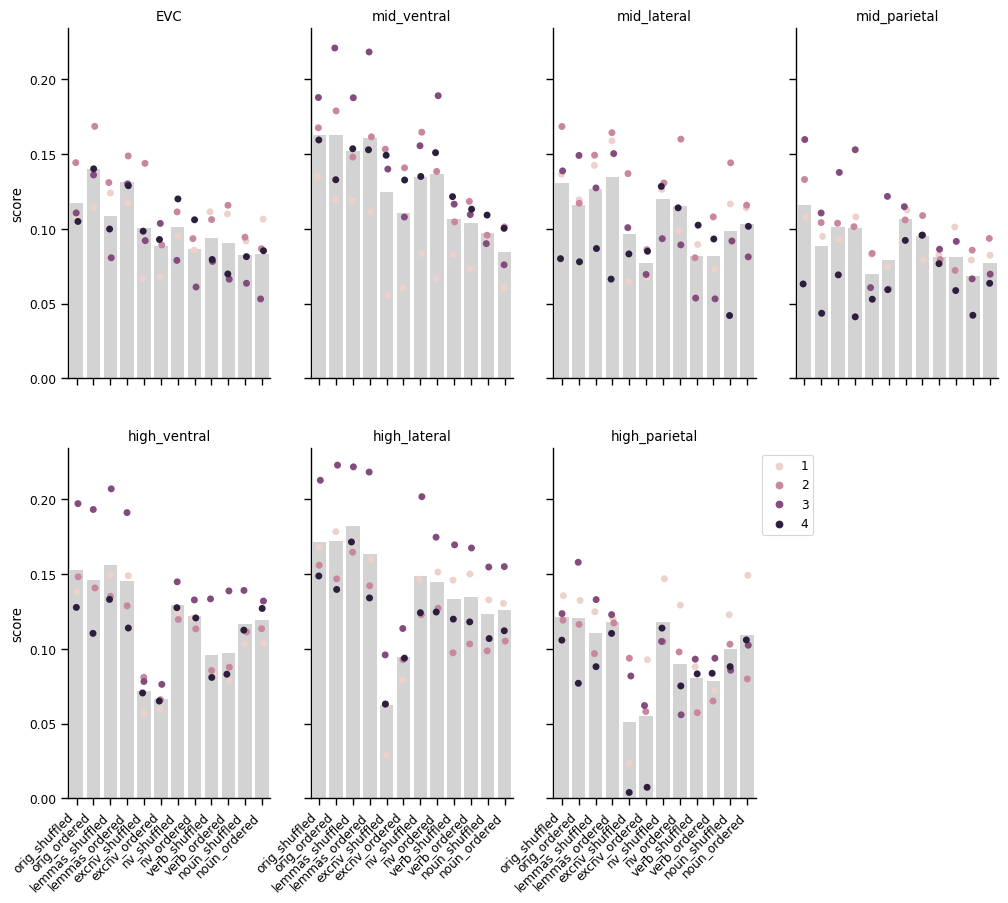

In [61]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 10))
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = max_scores.groupby('stream_name')
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='perturbation', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='perturbation', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(perturbations, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()